The simulation of ionizing fronts near the individual galaxies often show the "butterfly" shape of the ionizing fronts. The reason for that is simple. Any galaxy has the filaments "connected" to it and this whole system is located in Zeldovich "pancake". Therefore, even if the ionizing radiation escapes spherically symmetrically from the galaxy, the ionization front propagates slower in denser regions, and consequently the shape of the front becomes complicated.

In [1]:
# we start with importing all necessary components
%matplotlib inline

import numpy as np
from numpy import sin, cos, pi

import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML

from scipy.stats import rankdata, norm
from scipy.interpolate import griddata

# FastPM related libraries to work with snapshots
from nbodykit.source.catalog.file import BigFileCatalog
from nbodykit.source.mesh import BigFileMesh

from nbodykit.cosmology import Planck15
from nbodykit.cosmology import EHPower

from nbodykit.lab import *
from nbodykit import setup_logging, style

from skimage import measure

from reionprimer import *

/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


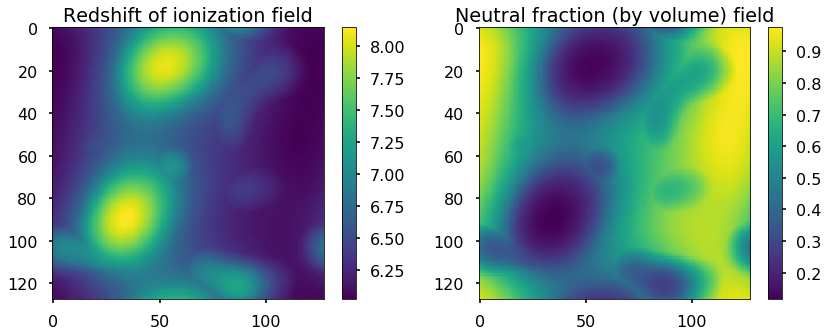

In [2]:
N=128
boxsize=10

part = BigFileCatalog('fastpm_0.1250', dataset='1/', header='Header')
q = part.to_mesh(Nmesh=N)
q = q.to_field()

halos = BigFileCatalog('fastpm_0.1250/fof/0.200/',header='Header')

M = np.array(halos['Mass'])
pos = np.array(halos['CMPosition'])

# we want to take only halos above 10^10 M_\Sun
filt = (M>1e9)

halo_field_m = np.zeros([N,N,N])

for i,(m,x,y,z) in enumerate(zip(M[filt],
                                 (pos[filt,0])/boxsize*N, 
                                 (pos[filt,1])/boxsize*N, 
                                 (pos[filt,2])/boxsize*N)):
    halo_field_m[int(x),int(y),int(z)] += 1.0 * m


# halo_field += q*1e10

def barrier(s, h):
#     return s*0 + 0.9
    return 4*(np.log10(s)+0.0)**2+h

def r_barrier(s, v):
    return v-4*(np.log10(s)+0.0)**2

sm_scales=np.array([1,2,4,8,16,32,64,128,256])
halo_field = halo_field_m + q*1e-2
field = get_trajectories(halo_field, sm_scales=sm_scales, filter_mode='gaussian', normalization='rankorder')

h_field = np.zeros([N,N,N,len(sm_scales)])
for i,scale in enumerate(sm_scales):
    h_field[:, :, :, i] = r_barrier(N/scale/boxsize, field[:,:,:,i])

h_field = h_field.max(3)

z_list = np.linspace(15,5,100)
f_list = reion_history(z_list)
f_field, z_field = convert_to_h_field(h_field, z_list, f_list)

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.imshow(z_field[0,:,:])
plt.title('Redshift of ionization field')
plt.colorbar()
plt.subplot(122)
plt.imshow(f_field[0,:,:])
plt.title('Neutral fraction (by volume) field')
plt.colorbar()

(10, 0)

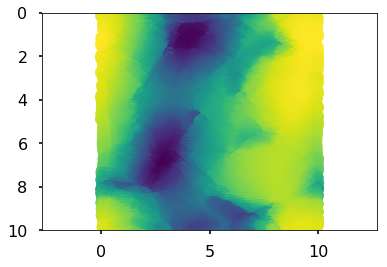

In [3]:
part = BigFileCatalog('fastpm_0.1429', dataset='1/', header='Header')
pos = part['Position'][:,:]

values = f_field.flatten()

plt.scatter(pos[:N**2,2], pos[:N**2,1], c=values[:N**2])
plt.axis('equal')
plt.xlim([0,boxsize])
plt.ylim([boxsize,0])

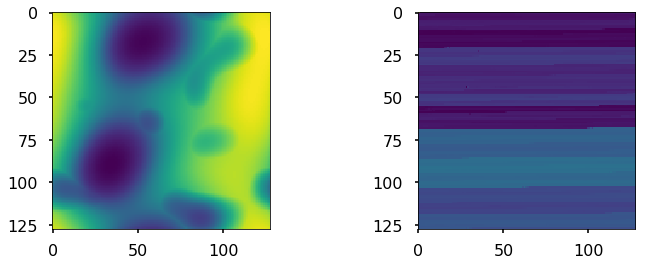

In [5]:
grid_0, grid_1, grid_2 = np.mgrid[0:N, 0:N, 0:N]

f_field_distorted = griddata(pos/boxsize*N, 
                             values, 
                             (grid_0, grid_1, grid_2), 
                             method='linear')

f_field_distorted_ranked = rankdata(f_field_distorted.flat).reshape([N,N,N]) / N**3

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.imshow(f_field[0,:,:])

plt.subplot(122)
plt.imshow(f_field_distorted_ranked[0,:,:])
